# DualGAN: Dual Adversarial Time Series Generation via GANs and Autoencoders

In [1]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import logging
tf.get_logger().setLevel(logging.ERROR)

# 1. DualGAN model
from dualgan import dualgan

# 2. Data loading
from data_loading import real_data_loading, sine_data_generation
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

## Data Loading

Load original dataset and preprocess the loaded data.


In [2]:
original_data = []
generated_data = []

In [3]:
## Data loading
data_name = 'stock'
seq_len = 24

if data_name in ['stock', 'electricity', 'ECG']:
  original_data.append(real_data_loading(data_name, seq_len))

print(data_name + ' dataset is ready.')

stock dataset is ready.


In [4]:
## Data loading
data_name = 'sine'
seq_len = 64

if data_name == 'sine':
  # Set number of samples and its dimensions
  no, dim = 10000, 4
  original_data.append(sine_data_generation(no, seq_len, dim))
    
print(data_name + ' dataset is ready.')

sine dataset is ready.


In [5]:
## Data loading
data_name = 'ECG'
seq_len = 140

if data_name in ['stock', 'electricity', 'ECG']:
  original_data.append(real_data_loading(data_name, seq_len))
   
print(data_name + ' dataset is ready.')

ECG dataset is ready.


In [6]:
## Data loading
data_name = 'SWANSF'
seq_len = 60

if data_name in ['SWANSF','stock', 'energy', 'ECG']:
  original_data.append(real_data_loading(data_name, seq_len))
   
print(data_name + ' dataset is ready.')

SWANSF dataset is ready.


## Set network parameters

DualGAN network parameters should be optimized for different datasets.

- hidden_dim: hidden dimensions -> input 'same' or a number like 8
- num_layer: number of layers
- iteration: number of training iterations
- batch_size: the number of samples in each batch

In [7]:
## Newtork parameters
parameters = dict()

parameters['hidden_dim'] = 'same'
parameters['iterations'] = 6 * 1000
parameters['batch_size'] = 128
parameters['num_layer'] = 4

## Run synthetic time-series data generation

DualGAN uses the original data and network parameters to return the generated synthetic data.

It also utilizes the number of samples that need to be generated. If you enter 'same', it will produce an equal number of synthetic samples to match the real samples that you have. Otherwise, please enter a specific number.

In [8]:
dualgan_result = dualgan(original_data[0], parameters, 'same')

Start Embedding Network Training
step: 0/8000, AE_loss: 3.3714, AE_D_loss: 1.3902
step: 1000/8000, AE_loss: 0.4329, AE_D_loss: 1.3612
step: 2000/8000, AE_loss: 0.4102, AE_D_loss: 1.3585
step: 3000/8000, AE_loss: 0.3715, AE_D_loss: 1.3222
step: 4000/8000, AE_loss: 0.3701, AE_D_loss: 1.3173
step: 5000/8000, AE_loss: 0.3642, AE_D_loss: 1.2424
step: 6000/8000, AE_loss: 0.3525, AE_D_loss: 1.2627
step: 7000/8000, AE_loss: 0.3638, AE_D_loss: 1.353
step: 7998/8000, AE_loss: 0.355, AE_D_loss: 1.3329
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/8000, S_loss: 0.0358
step: 1000/8000, S_loss: 0.0002
step: 2000/8000, S_loss: 1e-04
step: 3000/8000, S_loss: 1e-04
step: 4000/8000, S_loss: 1e-04
step: 5000/8000, S_loss: 1e-04
step: 6000/8000, S_loss: 0.0
step: 7000/8000, S_loss: 1e-04
step: 7999/8000, S_loss: 0.0
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/8000, D_loss: 5.3362, G_loss_u_g: 0.1755, G_loss_u_s: 0.5959, G_loss_s: 0.0127, G_lo

## Evaluate the generated data

### 1. Discriminative score

To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.

- metric_iteration: the number of iterations for metric computation.

In [13]:
metric_iteration = 6

discriminative_score = list()
for _ in range(metric_iteration):
  temp_disc = discriminative_score_metrics(original_data[0], dualgan_result)
  discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

Discriminative score: 0.1999


## Evaluate the generated data

### 2. Predictive score

To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

In [10]:
predictive_score = list()
for tt in range(metric_iteration):
  temp_pred = predictive_score_metrics(original_data[0], dualgan_result)
  predictive_score.append(temp_pred)   
    
print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

Predictive score: 0.0408


## Evaluate the generated data

### 3. Visualization

We visualize the original and synthetic data distributions using PCA and tSNE analysis.

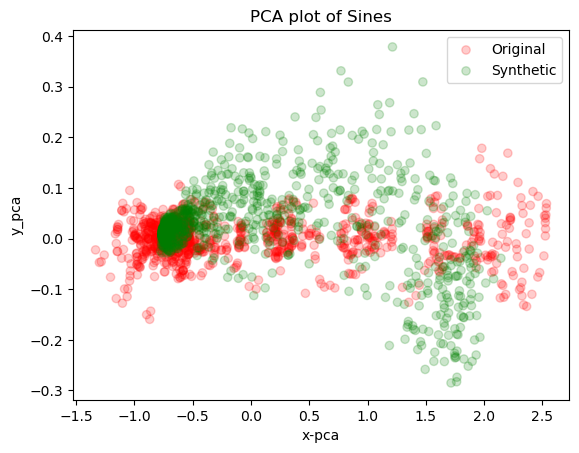

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.039572
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.328392
[t-SNE] KL divergence after 300 iterations: 1.319918


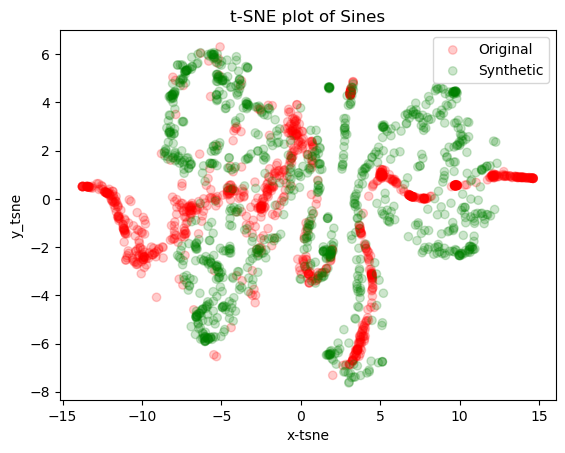

In [11]:
visualization(original_data[0], dualgan_result, 'pca', 'Sines')
visualization(original_data[0], dualgan_result, 'tsne', 'Sines')